In [92]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from math import log
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae, r2_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Функции определения Среднеквадратичной ошибки и Среднеквадратичной логарифмической ошибки

In [93]:
def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

def rmsle(y_true, y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [94]:
def cleaning(data):
    categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
    numerical_columns   = [c for c in data.columns if (data[c].dtype.name != 'object' and c != 'SalePrice')]
    answer_column = [c for c in data.columns if c == 'SalePrice']
    
    #заполняем пустые числовые медианным значением
    data = data.fillna(data.median(axis=0), axis=0)
    
    #заполняем пустые НЕчисловые самым частым значением
    data_describe = data.describe(include=[object])
    for c in categorical_columns:                   
        data[c] = data[c].fillna(data_describe[c]['top'])
    
    #переводим все НЕчисловые признаки в числовые
    binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2] #бинарные
    nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2] #небинарные
    #заменим значения в бинарных колонках на 0 и 1
    for c in binary_columns:
        top = data_describe[c]['top']
        top_items = data[c] == top #промежуточные данные, равные тем, которые являются популярнейшими в колонке
        data.loc[top_items, c] = 0 #делаем их значения 0
        data.loc[np.logical_not(top_items), c] = 1 #остальные 1
    #print(data[nonbinary_columns])
    #Здесь мы создали лишние фичи, разделив НЕчисловые небинарные на несколько, по которм мы говорим, относится ли данная строка
    #к этому признаку или нет
    data_nonbinary = pd.get_dummies(data[nonbinary_columns])
    #print(data_nonbinary)
    #начинаем нормализацию численных признаков
    data_numerical = data[numerical_columns]
    data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
    data_answer = data[answer_column] #не требуется нормализация
    #соединяем всё в таблицу
    data = pd.concat((data_numerical, data[binary_columns], data_nonbinary, data_answer), axis=1)
    data = pd.DataFrame(data, dtype=float)
    return data

Забираем данные из файла тренировочных данных и сразу "чистим", удаляя Nan-ы, заменяя их на популярнейшие в столбце значения (для усреднения выборки, хотя это не оптимальный вариант, но лучше я не придумал), и заменя все НЕчисловые значения на 0 и 1, разделив некоторые фичи на несколько отдельных столбцов

In [95]:
#data #Смотрим на наш изначальный датасет
#Понимаем, что нам не нравятся Nan-ы
#Сейчас мы их заменим на самые популярные записи в соответствующих столбцах, используя функцию выше

In [96]:
data = pd.read_csv('D:\Artem\Documents\BMSTU\ML\LR3\\train.csv')
data['SalePrice'] = np.log(data['SalePrice'])
data = cleaning(data)
#np.log(data['SalePrice'])
data['SalePrice']
#data

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
5       11.870600
6       12.634603
7       12.206073
8       11.774520
9       11.678440
10      11.771436
11      12.751300
12      11.877569
13      12.540758
14      11.964001
15      11.790557
16      11.911702
17      11.407565
18      11.976659
19      11.842229
20      12.692503
21      11.845103
22      12.345835
23      11.774520
24      11.944708
25      12.454104
26      11.811547
27      12.631340
28      12.242887
29      11.134589
          ...    
1430    12.165980
1431    11.875831
1432    11.074421
1433    12.136187
1434    11.982929
1435    12.066811
1436    11.699405
1437    12.885671
1438    11.916389
1439    12.190959
1440    12.160029
1441    11.913713
1442    12.644328
1443    11.703546
1444    12.098487
1445    11.767568
1446    11.969717
1447    12.388394
1448    11.626254
1449    11.429544
1450    11.820410
1451    12.567551
1452    11.884489
1453    11.344507
1454    12

In [97]:
#data
#я принял общую площадь равной сумме площадей с 1 и 2 этажа, если она меньше суммы оных
data.loc[data['TotalBsmtSF'] < data['1stFlrSF'] + data['2ndFlrSF'], 'TotalBsmtSF'] = data['1stFlrSF'] + data['2ndFlrSF']

In [98]:
corr = data.corr()

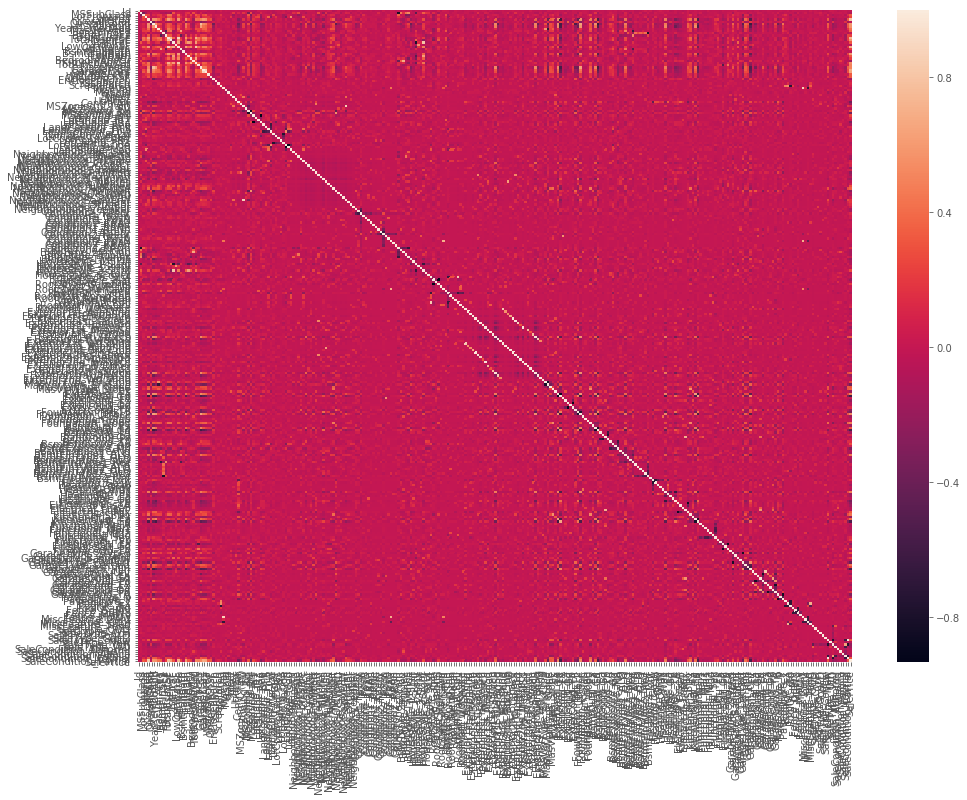

In [99]:
_, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax = ax)
#ЦЭ ЖЭСТЬ!!!

Смотрим на то, как фичи влияют на цену, с помощью корреляции, а не вручную изучая каждый из 250-ти признаков. Выберу те, которые наиболее сильно влияют на цену, на всякий случай, сохранив данные, которые удалю из самого датасета

In [100]:
drop_cols = []
for col in corr.columns:
    if (abs(corr[col]['SalePrice']) < 0.5  and col != 'SalePrice'):
        drop_cols.append(col)
        data.drop(col, inplace = True, axis = 1)

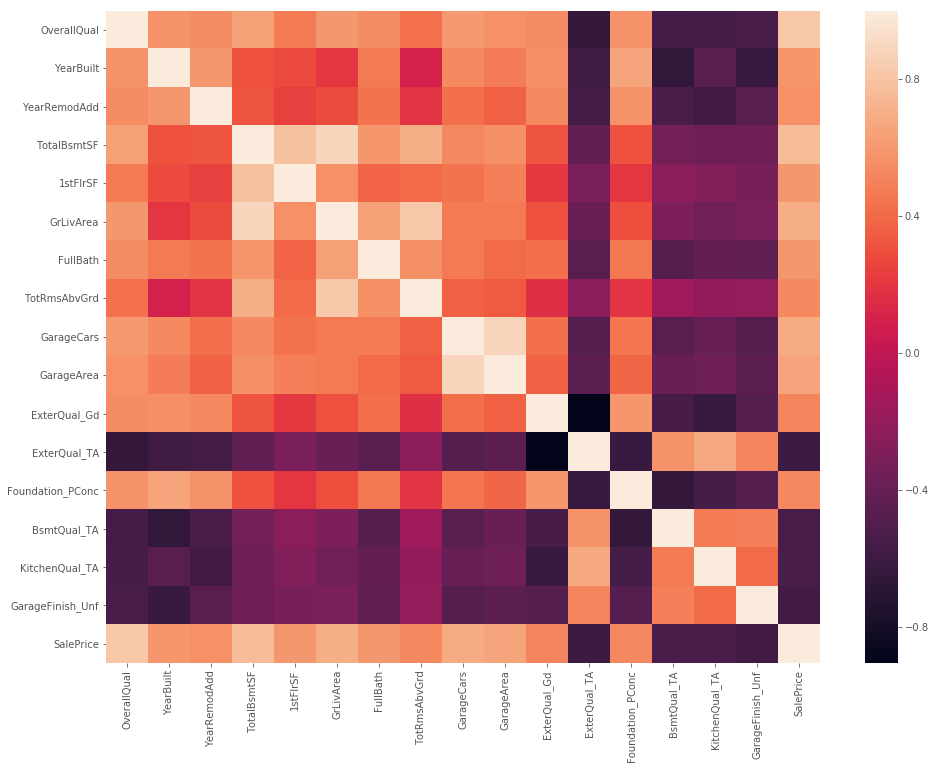

In [101]:
corr = data.corr()
_, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax = ax)

In [102]:
data.drop(['YearRemodAdd','1stFlrSF'], inplace = True, axis = 1)
data=data[(np.abs(stats.zscore(data)) < 3).all(axis=1)] # красиво
#data

Осталось 14 колонок из 81, неплохо, я считаю

А теперь мы все это в линейную регрессию, и посмотрим, что вышло

In [103]:
y = data['SalePrice']                 # ответ
data.drop(['SalePrice'], inplace = True, axis=1)  # входные фичи
x = data

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.75, random_state = 11)

In [104]:
regr = LinearRegression(fit_intercept=True)
regr.fit(x_train, y_train)
y_valid_predict = regr.predict(x_valid)

print('Coefficients: \n', regr.coef_)
print("RMSE: %.2f" % rmse(y_valid, y_valid_predict))
print("RMSLE: %.2f" % rmsle(y_valid, y_valid_predict))
print('Variance score: %.2f' % r2_score(y_valid, y_valid_predict))

Coefficients: 
 [ 0.11357281  0.07039588  0.10328104  0.07341193 -0.01717244  0.00235896
  0.00763585  0.04560881 -0.05332321 -0.07907442 -0.01993187 -0.00349113
 -0.05036067 -0.04867401]
RMSE: 0.16
RMSLE: 0.01
Variance score: 0.83


Программа выдает результаты, сходные с теми, что выше

In [114]:
x_test = pd.read_csv('D:\Artem\Documents\BMSTU\ML\LR3\\test.csv')
y_test = pd.read_csv('D:\Artem\Documents\BMSTU\ML\LR3\\sample_submission.csv')

x_test = cleaning(x_test)
x_test = x_test[['OverallQual','YearBuilt','TotalBsmtSF','GrLivArea','FullBath','TotRmsAbvGrd','GarageCars','GarageArea','ExterQual_Gd','ExterQual_TA','BsmtQual_Ex','KitchenQual_Ex','KitchenQual_TA','GarageFinish_Unf']]
y_test = y_test[['SalePrice']]
y_test = np.log(y_test)
y_test

,SalePrice
0,12.039292
1,12.142911
2,12.120426
3,12.096913
4,11.923246
5,12.084758
6,12.055660
7,12.073175
8,11.995424
9,11.987458


In [115]:
y_test_predict = regr.predict(x_test)
print(y_test)
y_test = np.exp(y_test)
print(y_test)
print('Coefficients: \n', regr.coef_)
print('Variance score: %.2f' % r2_score(y_test, y_test_predict))

      SalePrice
0     12.039292
1     12.142911
2     12.120426
3     12.096913
4     11.923246
5     12.084758
6     12.055660
7     12.073175
8     11.995424
9     11.987458
10    11.969928
11    11.886496
12    11.980877
13    12.008643
14    11.924317
15    12.097713
16    12.128298
17    12.113695
18    12.117534
19    12.143257
20    12.136423
21    11.971810
22    12.157685
23    11.899437
24    12.132724
25    12.068823
26    12.214738
27    12.001422
28    11.997388
29    12.018815
...         ...
1429  11.986148
1430  12.166123
1431  12.093752
1432  12.199445
1433  12.010989
1434  11.963287
1435  12.008754
1436  12.269010
1437  12.193335
1438  12.101306
1439  12.122539
1440  12.410169
1441  12.045622
1442  12.183808
1443  12.151457
1444  12.317915
1445  12.039636
1446  12.028207
1447  12.142651
1448  12.188550
1449  11.830670
1450  12.014227
1451  12.146887
1452  12.060570
1453  12.021394
1454  12.026235
1455  12.012420
1456  12.297842
1457  12.127702
1458  12.142823

[1459 r

In [116]:
predictions = pd.DataFrame({'SalePrice':y_test_predict.round()}, index=range(1461,2920))
predictions.index.name = 'Id'
predictions.to_csv('D:\Artem\Documents\BMSTU\ML\LR3\\Results.csv')

In [117]:
class LinearRegression():
    
    def __init__(self, learning_rate=1, change_rate=True, xkf=50, max_iter=100, eps=0.01, print_int=100):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.change_rate = change_rate
        self.xkf = xkf
        self.eps = eps
        self.print_int = print_int
        self.w = None
        self.iter = 0
        
    def fit(self, x, y):
        
        d = 1
        if (len(x.shape) != 1): # Если не одномерный случай
            d = x.shape[1]      # Количество измерений (атрибутов)
        n = x.shape[0]          # Количество элементов (точек)
        
        u = self.learning_rate  # Коэффициент шага (переменный)
        t = 0                   # Номер итерации
        
        work = True
        
        w = np.array([0.0 for _ in range(d+1)]) # Веса, d-й является свободным
        
        while (work):
            t += 1
            if (self.change_rate):
                u = self.learning_rate / (t/self.xkf + 1)
            
            dQ = np.array([0.0 for _ in range(d+1)])
            
            for k in range(d+1):
                for i in range(n):
                    s = 0.0
                    if (d == 1):
                        s += x[i] * w[0]
                    else:
                        for j in range(d):
                            s += x[i][j] * w[j]
                    s += w[d]
                    s -= y[i]
                    if (k < d):
                        if (d == 1):
                            s *= x[i]
                        else:
                            s *= x[i][k]
                    dQ[k] += s
                dQ[k] *= (2/float(n))
            
            w = w - u * dQ
            
            p = np.array([0.0 for _ in range(n)])
            
            for i in range(n):
                if (d == 1):
                    p[i] += x[i] * w[0]
                else:
                    for j in range(d):
                        p[i] += x[i][j] * w[j]
                p[i] += w[d]
            
            if (t >= self.max_iter or np.all(np.absolute(u * dQ) <= self.eps)):
                work = False
            
            if (self.print_int != 0 and (t % self.print_int == 0 or t == 1)):
                PrintGraph(x, y, p)
                
        self.iter = t
        self.w = w
        return self
    
    def predict(self, x):
        p = np.array([0.0 for _ in range(x.shape[0])])
        for i in range(x.shape[0]):
            if (len(x.shape) == 1):
                p[i] = x[i] * self.w[0] + self.w[1]
            else:
                for j in range(x.shape[1]):
                    p[i] += x[i][j] * self.w[j]
                p[i] += self.w[x.shape[1]]
        return p